# 계절성 지수 산출모델

In [1]:
import pandas as pd
import numpy as np
import math

## 01.데이터 불러오기  (과거 3년 판매실적)

##### 1. csv 파일 통해 불러오기

In [2]:
sellOutDt3Year= pd.read_csv("../dataset/kopo_channel_seasonality_new.csv")

In [3]:
sellOutDt3Year.head()

,REGIONID,PRODUCT,YEARWEEK,QTY
0,A60,PRODUCT4,201402,71.0
1,A60,PRODUCT59,201402,22275.0
2,A60,PRODUCT34,201402,4463.0
3,A60,PRODUCT47,201402,0.0
4,A60,PRODUCT56,201402,23.0


In [4]:
print(sellOutDt3Year.dtypes)

REGIONID     object
PRODUCT      object
YEARWEEK      int64
QTY         float64
dtype: object


## 02. 로딩 데이터 기본정제

##### 1. 컬럼명  전체 소문자로 변경

In [5]:
sellOutDt3Year.columns = sellOutDt3Year.columns.str.lower()

##### 2. 키 컬럼 생성 (예: regionid + product -> key)

In [6]:
sellOutDt3Year["keycol"] = sellOutDt3Year["regionid"]+'_'+sellOutDt3Year["product"] 

In [7]:
sellOutDt3Year.head()

,regionid,product,yearweek,qty,keycol
0,A60,PRODUCT4,201402,71.0,A60_PRODUCT4
1,A60,PRODUCT59,201402,22275.0,A60_PRODUCT59
2,A60,PRODUCT34,201402,4463.0,A60_PRODUCT34
3,A60,PRODUCT47,201402,0.0,A60_PRODUCT47
4,A60,PRODUCT56,201402,23.0,A60_PRODUCT56


In [8]:
##### 3. 컬럼명 변경
#selloutDataFromOracle.rename(columns={"regionid":"accountid"}, inplace = True)

##### 3. 컬럼위치 변경

In [9]:
sellOutDt3Year = sellOutDt3Year[["keycol","regionid","product","yearweek","qty"]]

In [10]:
sellOutDt3Year.dtypes

keycol       object
regionid     object
product      object
yearweek      int64
qty         float64
dtype: object

## 03. 데이터 정제

##### 1. 특정 제품군으로 필터 (TBD: 파라미터 통해)

In [11]:
sellOutDt3Year.head()

,keycol,regionid,product,yearweek,qty
0,A60_PRODUCT4,A60,PRODUCT4,201402,71.0
1,A60_PRODUCT59,A60,PRODUCT59,201402,22275.0
2,A60_PRODUCT34,A60,PRODUCT34,201402,4463.0
3,A60_PRODUCT47,A60,PRODUCT47,201402,0.0
4,A60_PRODUCT56,A60,PRODUCT56,201402,23.0


In [12]:
f1sellOutDt3Year = sellOutDt3Year

##### 2. 53주차 값 제거 및 qty 음수값 제거

In [13]:
f1sellOutDt3Year = f1sellOutDt3Year[ f1sellOutDt3Year.yearweek.astype(str).str[4:] != '53']

In [14]:
f1sellOutDt3Year.head()

,keycol,regionid,product,yearweek,qty
0,A60_PRODUCT4,A60,PRODUCT4,201402,71.0
1,A60_PRODUCT59,A60,PRODUCT59,201402,22275.0
2,A60_PRODUCT34,A60,PRODUCT34,201402,4463.0
3,A60_PRODUCT47,A60,PRODUCT47,201402,0.0
4,A60_PRODUCT56,A60,PRODUCT56,201402,23.0


##### 3. QTY 0 제거 [반품 -> 0]

In [15]:
f1sellOutDt3Year.loc[ f1sellOutDt3Year.qty < 0 , 'qty']= 0
f1sellOutDt3Year.loc[ f1sellOutDt3Year.qty > 0 , 'qty']= f1sellOutDt3Year.qty
f1sellOutDt3Year.head()

C:\Users\kopo\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,keycol,regionid,product,yearweek,qty
0,A60_PRODUCT4,A60,PRODUCT4,201402,71.0
1,A60_PRODUCT59,A60,PRODUCT59,201402,22275.0
2,A60_PRODUCT34,A60,PRODUCT34,201402,4463.0
3,A60_PRODUCT47,A60,PRODUCT47,201402,0.0
4,A60_PRODUCT56,A60,PRODUCT56,201402,23.0


In [16]:
f1sellOutDt3Year = f1sellOutDt3Year
print(f1sellOutDt3Year.dtypes)
f1sellOutDt3Year.head()

keycol       object
regionid     object
product      object
yearweek      int64
qty         float64
dtype: object


,keycol,regionid,product,yearweek,qty
0,A60_PRODUCT4,A60,PRODUCT4,201402,71.0
1,A60_PRODUCT59,A60,PRODUCT59,201402,22275.0
2,A60_PRODUCT34,A60,PRODUCT34,201402,4463.0
3,A60_PRODUCT47,A60,PRODUCT47,201402,0.0
4,A60_PRODUCT56,A60,PRODUCT56,201402,23.0


## 04.계절성 지수 산출

In [17]:
refinedData = f1sellOutDt3Year

##### 1.이동(평균/표준펴나) 함수 정의

In [18]:
ma_section = 17
std_section = 9
sm_section = 9

In [19]:
def ma_function(data, section, flag):    
    data = data.reset_index(drop=True)
    if(flag=="ma"):
        data["ma"]=data["qty"].rolling(window=section, center=True, min_periods=1).mean()
    else:
        data["sm"]=data["refined_qty"].rolling(window=section, center=True, min_periods=1).mean()
    return data

In [20]:
def std_function(data, section):
    data = data.reset_index(drop=True)
    data["mstd"]=data["ma"].rolling(window=section ,center=True, min_periods=1).std()
    return data

##### 2. 지역, 상품별 판매 추세량 생성

In [21]:
refinedData.sort_values(["keycol","yearweek"], inplace=True)

C:\Users\kopo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
# 지역별 상품별 함수적용 groupby 
refinedData =refinedData.groupby(["keycol"]).apply(ma_function, ma_section, "ma")

In [23]:
refinedData.reset_index(drop=True,inplace=True) #groupby에러
refinedData.head()

,keycol,regionid,product,yearweek,qty,ma
0,A00_PRODUCT34,A00,PRODUCT34,201401,661.0,514.444444
1,A00_PRODUCT34,A00,PRODUCT34,201402,679.0,516.800000
2,A00_PRODUCT34,A00,PRODUCT34,201403,578.0,503.363636
3,A00_PRODUCT34,A00,PRODUCT34,201404,532.0,490.750000
4,A00_PRODUCT34,A00,PRODUCT34,201405,516.0,480.230769


##### 3. 지역, 상품별 이상치 정제

In [24]:
refinedData = refinedData.groupby(["keycol"]).apply(std_function,std_section)
refinedData.reset_index(drop=True,inplace=True) #groupby에러
refinedData.head()

,keycol,regionid,product,yearweek,qty,ma,mstd
0,A00_PRODUCT34,A00,PRODUCT34,201401,661.0,514.444444,15.591135
1,A00_PRODUCT34,A00,PRODUCT34,201402,679.0,516.800000,19.362507
2,A00_PRODUCT34,A00,PRODUCT34,201403,578.0,503.363636,23.007444
3,A00_PRODUCT34,A00,PRODUCT34,201404,532.0,490.750000,26.416662
4,A00_PRODUCT34,A00,PRODUCT34,201405,516.0,480.230769,29.984975


In [25]:
refinedData["upper_band"]=refinedData["ma"]+refinedData["mstd"]
refinedData["lower_band"]=refinedData["ma"]-refinedData["mstd"]

In [26]:
refinedData['refined_qty'] = \
np.where(refinedData['qty']>refinedData['upper_band'],refinedData['ma'],\
        np.where(refinedData['qty']<refinedData['lower_band'],refinedData['ma'],refinedData['qty']))

In [27]:
refinedData.head()

,keycol,regionid,product,yearweek,qty,ma,mstd,upper_band,lower_band,refined_qty
0,A00_PRODUCT34,A00,PRODUCT34,201401,661.0,514.444444,15.591135,530.035579,498.853309,514.444444
1,A00_PRODUCT34,A00,PRODUCT34,201402,679.0,516.800000,19.362507,536.162507,497.437493,516.800000
2,A00_PRODUCT34,A00,PRODUCT34,201403,578.0,503.363636,23.007444,526.371081,480.356192,503.363636
3,A00_PRODUCT34,A00,PRODUCT34,201404,532.0,490.750000,26.416662,517.166662,464.333338,490.750000
4,A00_PRODUCT34,A00,PRODUCT34,201405,516.0,480.230769,29.984975,510.215744,450.245795,480.230769


##### 4. 지역, 상품별 판매 추세선 생성

In [28]:
# 지역별 상품별 함수적용 groupby 
refinedData =refinedData.groupby(["keycol"]).apply(ma_function, sm_section, "sm")
refinedData.reset_index(drop=True,inplace=True) #groupby에러
refinedData.head()

,keycol,regionid,product,yearweek,qty,ma,mstd,upper_band,lower_band,refined_qty,sm
0,A00_PRODUCT34,A00,PRODUCT34,201401,661.0,514.444444,15.591135,530.035579,498.853309,514.444444,501.117770
1,A00_PRODUCT34,A00,PRODUCT34,201402,679.0,516.800000,19.362507,536.162507,497.437493,516.800000,495.633856
2,A00_PRODUCT34,A00,PRODUCT34,201403,578.0,503.363636,23.007444,526.371081,480.356192,503.363636,490.067115
3,A00_PRODUCT34,A00,PRODUCT34,201404,532.0,490.750000,26.416662,517.166662,464.333338,490.750000,484.543100
4,A00_PRODUCT34,A00,PRODUCT34,201405,516.0,480.230769,29.984975,510.215744,450.245795,480.230769,482.927200


##### 5. 계절성 지수 산출 (계절성 지수 = 실제판매량/스무딩처리)

In [29]:
refinedData["ratio"]=refinedData.qty/refinedData.sm

In [30]:
refinedData.head()

,keycol,regionid,product,yearweek,qty,ma,mstd,upper_band,lower_band,refined_qty,sm,ratio
0,A00_PRODUCT34,A00,PRODUCT34,201401,661.0,514.444444,15.591135,530.035579,498.853309,514.444444,501.117770,1.319051
1,A00_PRODUCT34,A00,PRODUCT34,201402,679.0,516.800000,19.362507,536.162507,497.437493,516.800000,495.633856,1.369963
2,A00_PRODUCT34,A00,PRODUCT34,201403,578.0,503.363636,23.007444,526.371081,480.356192,503.363636,490.067115,1.179430
3,A00_PRODUCT34,A00,PRODUCT34,201404,532.0,490.750000,26.416662,517.166662,464.333338,490.750000,484.543100,1.097942
4,A00_PRODUCT34,A00,PRODUCT34,201405,516.0,480.230769,29.984975,510.215744,450.245795,480.230769,482.927200,1.068484


In [31]:
refinedData.to_csv("./kopo_batch_season_middle_result.csv", index=False)

##### 6. 주차별 계절성 지수 산출

In [32]:
refinedData["week"]=refinedData.yearweek.astype(str).str[4:6]

In [33]:
seasonResult = refinedData.groupby(['keycol','week']).mean()[['ratio']]

In [34]:
seasonResult.reset_index(inplace=True)

In [35]:
seasonResult.head()

,keycol,week,ratio
0,A00_PRODUCT34,01,0.932722
1,A00_PRODUCT34,02,1.092057
2,A00_PRODUCT34,03,0.833640
3,A00_PRODUCT34,04,1.009971
4,A00_PRODUCT34,05,0.710346


##### 5. 데이터 저장

In [36]:
seasonResult.dtypes

keycol     object
week       object
ratio     float64
dtype: object

In [37]:
seasonResult.to_csv("./kopo_batch_season_result.csv", index=False)

## 05. 시각화

In [38]:
keyList=["A00_PRODUCT34"]

In [39]:
visualData = refinedData[ (refinedData.keycol.isin(keyList)) & 
                          (refinedData.yearweek > 201600)]
visualData.head()

,keycol,regionid,product,yearweek,qty,ma,mstd,upper_band,lower_band,refined_qty,sm,ratio,week
104,A00_PRODUCT34,A00,PRODUCT34,201601,21.0,63.588235,12.486567,76.074802,51.101668,63.588235,65.823529,0.319035,01
105,A00_PRODUCT34,A00,PRODUCT34,201602,22.0,58.352941,10.742803,69.095745,47.610138,58.352941,61.712418,0.356492,02
106,A00_PRODUCT34,A00,PRODUCT34,201603,23.0,55.882353,9.151361,65.033714,46.730992,55.882353,58.019608,0.396418,03
107,A00_PRODUCT34,A00,PRODUCT34,201604,28.0,53.176471,7.740213,60.916684,45.436257,53.176471,54.745098,0.511461,04
108,A00_PRODUCT34,A00,PRODUCT34,201605,19.0,51.529412,13.324842,64.854254,38.204569,51.529412,48.124183,0.394812,05


In [40]:
visualData2 = visualData[["yearweek","qty","ma","sm","ratio","upper_band","lower_band","refined_qty"]].set_index('yearweek')
visualData2.head()

,qty,ma,sm,ratio,upper_band,lower_band,refined_qty
yearweek,,,,,,,
201601,21.0,63.588235,65.823529,0.319035,76.074802,51.101668,63.588235
201602,22.0,58.352941,61.712418,0.356492,69.095745,47.610138,58.352941
201603,23.0,55.882353,58.019608,0.396418,65.033714,46.730992,55.882353
201604,28.0,53.176471,54.745098,0.511461,60.916684,45.436257,53.176471
201605,19.0,51.529412,48.124183,0.394812,64.854254,38.204569,51.529412


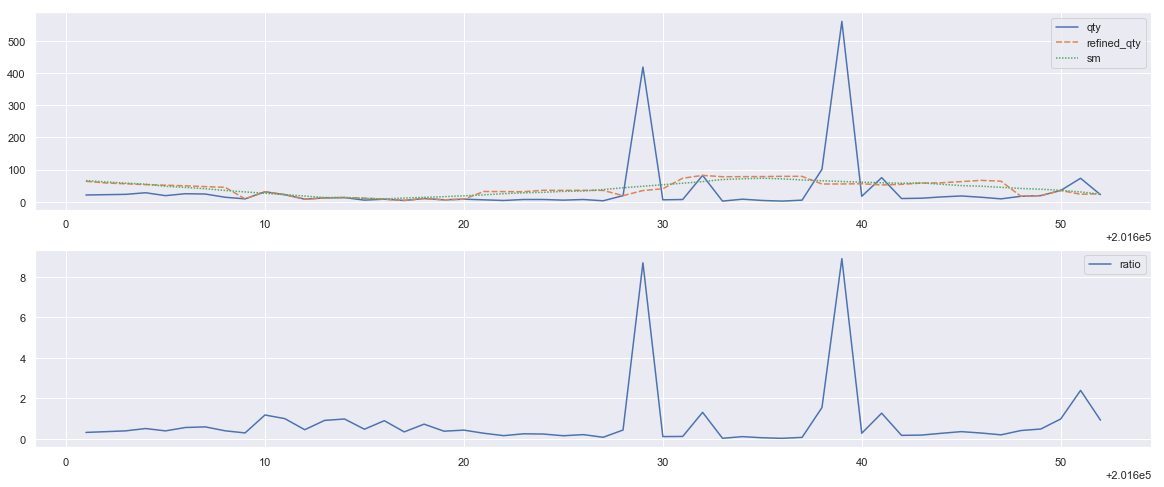

In [41]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
# 커맨드뷰에서 차트 시여
%matplotlib inline
plt.figure(figsize=(20,8))

plt.subplot(211)
sns.lineplot( data=[visualData2.qty, visualData2.refined_qty, visualData2.sm])
plt.subplot(212)
sns.lineplot(data=[visualData2.ratio])